#Spectral clustering for MINST dataset - Version 0.0# 
$N$: number of data points

$K$: number of clusters


##Road Map##
1. Input data and label
2. Compute similarity matrix $M$ with some kernel (say, Gaussian kernel), apply some thereshold to get adjacency matrix $W$
3. Compute the Laplacian matrix $L=D-W$ of the graph (every node represents one data point)
4. Find the eigenvectors corresponding to the $K$ minimal eigenvalues of $L$ and construct matrix $H$ ($N$ × $K$)
5. Apply K-means algrithm to classify rows of $H$

In [66]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import random

In [67]:
X_full, y_full = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
print(X_full.shape, y_full.shape)
print(X_full)

(70000, 784) (70000,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


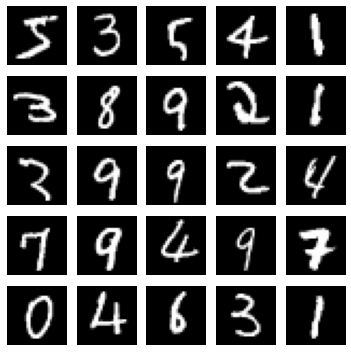

In [88]:
# Visualise a sample of the data
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    ax = axs[i // 5][i % 5]
    ax.imshow(X_full[50*i:50*i+1].reshape(28,28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [89]:
N = 50
K = 10
X = X_full[0:N,:]
y = y_full[0:N]
print(X.shape,y.shape)

(50, 784) (50,)


In [90]:
def Adjacency_GaussianKernel(X):
  W = np.zeros([N,N])
  M = np.zeros([N,N])
  epsilon = 0.3
  gamma = 1e-7
  for i in range(N):
    for j in range(N):
      temp = np.inner( (X[i,:]-X[j,:]), (X[i,:]-X[j,:]) )
      #M[i,j] = np.exp(-gamma*temp)
      W[i,j] = np.exp(-gamma*temp)
      W[i,j] = 1e-12*temp
      #if M[i,j]>epsilon:
      #  W[i,j] = 1
  return W,M

def Laplacian(X):
  D = np.zeros([N,N])
  W,M = Adjacency_GaussianKernel(X)
  for i in range(N):
    for j in range(N):
      D[i,i] = D[i,i]+W[i,j]
  
  v, Q = np.linalg.eig(D)
  V = np.diag(v**(-0.5))
  DD = Q*V*np.linalg.inv(Q)
  L = np.identity(N) - DD*W*DD
  L = np.array(L)
  return D,L

def Laplacian(X):
  D = np.zeros([N,N])
  W,M = Adjacency_GaussianKernel(X)
  for i in range(N):
    for j in range(N):
      D[i,i] = D[i,i]+W[i,j]
  L = D - W
  return D,L

def H_constrcution(X):
  H = np.zeros([K,N])
  D,L = Laplacian(X)
  eigenValues, eigenVectors = np.linalg.eig(L)
  idx = eigenValues.argsort()[::1]
  eigenValues = eigenValues[idx]
  eigenVectors = eigenVectors[:,idx]
  for i in range(K):
    H[i] = eigenVectors[i]
  H = H.T
  return H

In [91]:
def K_means_clustering_standard_SED(X,K):
    """
    Performs K-means-clustering with standard squared Euclidean distance
    Input : X : dataset (N : number samples x m : size of data/element)
            K : numbers of clusters  
    output : centroids : list with 
    centroids : list of element
    clusters : list of list of the indexes of each cluster 
    """
    
    N=len(X)
    random.seed(1000) #since we use random, we are going to set a seed,... not necessary
    centroids_index = random.sample(range(N), K)#Initialize centroids
    centroids=X[centroids_index]
    clusters = asign_clusters(centroids,X,K) #asign to cluster
    new_centroids=update_centroids(clusters,X,K) 

    number_it=1
    while loss(centroids,clusters,X,K)!= loss(new_centroids,asign_clusters(new_centroids,X,K),X,K): #while the centroids change, then (1) is improving by construction , we can also use > instead
        centroids=new_centroids.copy() #copy, python basic = to copy isn't enougth
        clusters = asign_clusters(centroids,X,K) #asign to cluster
        new_centroids=update_centroids(clusters, X,K)
        number_it +=1

    
    print("Iterations numbers " + str(number_it))

    return centroids


def loss(centroids,clusters,X,K):
    """
    Calculate loss : with squared euclidean distance
    Input : 
            centroids and clusters to compute loss from
            X : dataset 
            K : numbers of clusters  
    output : squared euclidean distance : L(X,k)=sum sum || Xi - Cl ||^2
    """
    loss=0
    for l in range(K):
        for i in clusters[l]:
            loss+=np.inner(X[i]-centroids[l],X[i]-centroids[l])
    return loss

def update_centroids(clusters, X,K):
    """
    update the new centroids computing the mean on clusters 
    """
    new_centroids=[]#placeholder
    for l in range(K):
        new_centroids.append(sommer(X[clusters[l]])/len(clusters[l]) ) #sommer is a function that compute the vector sum of a list of vectors
    return new_centroids

def asign_clusters(centroids,X,K): 
    """
    For each centroids, we asign each element of X in it's corresponding cluster
    We do the argmin of the standard squared euclidian norm 
    """
    clusters=[[] for i in range(K)] #placeholder
    for i in range(len(X)): 
        sed=[np.inner(X[i]-centroids[j],X[i]-centroids[j]) for j in range(K)] #for each element xi of X, sed is the distance from each centroids
        clusters[np.argmin(sed)].append(i)
    return clusters


def sommer(list_of_list):
    """
    Compute the vector sum of a list of vectors
    """
    Somme= [0]*len(list_of_list[0]) #placeholder, nul vector
    for i in range(len(list_of_list)):
        Somme=np.add(list_of_list[i],Somme)
    return Somme

In [92]:
#Compute the accuracy of the clustering

def accuracy(cluster,y,K):
  """
  computes the accuracy of of the cluster
  input : clusters indexes, y : true labels 

  return accuracy : A =sum_k |{i ∈ Ck : i = mk}/number of elements
  """
  acc=0
  card=0
  
  for l in range(K):
    #find the mk : most frequent digit of cluster l
    mk= most_freq_digit(y[cluster[l]],K)
    print('The '+str(l+1)+'th cluster corresponds to the number '+str(mk))
    for element in y[cluster[l]]: 
      if int(element) == mk :
        acc+=1
      card +=1
  return acc/card #in fact card = len(y)


def most_freq_digit(liste,K):
  """
  find the most freq digit in liste, we suppose that liste contains int, from 0 to K-1
  """
  compteur=[0]*K #store how much time we see each element in the list
  for element in liste:
    element=int(element)
    compteur[element] += 1
  max_elem=max(compteur) 
  index=compteur.index(max_elem)
  return index

In [93]:
H_constrcution(X)

array([[-1.41421356e-01, -1.41421356e-01, -1.41421356e-01,
        -1.41421356e-01, -1.41421356e-01, -1.41421356e-01,
        -1.41421356e-01, -1.41421356e-01, -1.41421356e-01,
        -1.41421356e-01],
       [ 1.24036023e-02,  3.98032194e-03, -4.97832808e-03,
         5.01347889e-03,  1.12673682e-02,  6.44366622e-03,
         5.19825817e-03,  1.42287054e-03,  3.34240588e-03,
        -9.20857212e-03],
       [-1.05062943e-02, -7.81787380e-04,  3.71036110e-03,
        -2.94614247e-04, -1.22820056e-02,  4.03551664e-04,
        -8.87454386e-03,  8.21186857e-04, -2.58766200e-02,
         4.90876780e-03],
       [-1.48000809e-02, -1.51030557e-03, -3.66776638e-03,
        -2.83855765e-02, -3.47128538e-02, -2.43046976e-02,
        -8.86906422e-05, -6.01065128e-03, -1.02330478e-01,
        -4.59632243e-02],
       [ 1.91577863e-03, -3.80055466e-04,  2.49946739e-03,
        -7.35546550e-03,  1.32650318e-02,  2.73058715e-03,
         3.76402403e-02, -1.80256267e-03, -7.95351501e-01,
         2.

In [94]:
# Do K-means clustering
H = H_constrcution(X)
print(H.shape)
centroids = K_means_clustering_standard_SED(H,K)
clusters = asign_clusters(centroids,H,K) #cluster result
print(clusters)

(50, 10)
Iterations numbers 5
[[0, 12, 23, 24, 26, 41], [27, 31, 32], [42, 43], [1, 2, 3, 6, 7, 8, 9, 10, 11, 17, 20, 21, 33, 34, 35, 36, 37, 38, 39, 44, 45, 46, 47, 48, 49], [25], [14, 22], [4, 5], [28, 29], [15, 16, 18], [13, 19, 30, 40]]


In [95]:
accuracy(clusters,y,K)

The 1th cluster corresponds to the number 1
The 2th cluster corresponds to the number 3
The 3th cluster corresponds to the number 7
The 4th cluster corresponds to the number 0
The 5th cluster corresponds to the number 2
The 6th cluster corresponds to the number 1
The 7th cluster corresponds to the number 2
The 8th cluster corresponds to the number 2
The 9th cluster corresponds to the number 2
The 10th cluster corresponds to the number 1


0.28